### Sachs data

[Sachs Protein Data](https://perso.univ-rennes1.fr/valerie.monbet/GM/Sachs.html)

In [2]:
%pip install ../. 
%pip install cdt
from cdt.data import load_dataset
import networkx as nx
import jax
import jax.numpy as jnp
import jax.random as random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

print(f"JAX backend: {jax.default_backend()}")
key=random.PRNGKey(343)

def permute_random_rows(key, X, p=0.5):
    key, subk = random.split(key)
    permutation = random.permutation(subk, jnp.arange(X.shape[1]))
    
    key, subk = random.split(key)
    permute = random.bernoulli(subk, p=jnp.float32(p), shape=(X.shape[0],))

    [X := X.at[i,:].set(X[i,permutation]) for i in range(X.shape[0]) if permute[i]]
    
    return X, permute, permutation

def permute_directed_graph(graph, permutation):
    g, perm, perm_g = graph, permutation, jnp.zeros_like(graph)
    for i in range(g.shape[0]):
        for j in range(g.shape[1]):
                perm_g = perm_g.at[i,j].set(g[perm[i],perm[j]])
                
    return perm_g

JAX backend: cpu


In [4]:
# Load the graph and data
sachs_data, sachs_graph = load_dataset("sachs")

adjacency = jnp.array(nx.to_numpy_array(sachs_graph))
print('Adjacency matrix: \n', adjacency)

data = jnp.array(sachs_data.values)[:853,:]
print('Data shape: \n', data.shape)

Adjacency matrix: 
 [[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Data shape: 
 (853, 11)


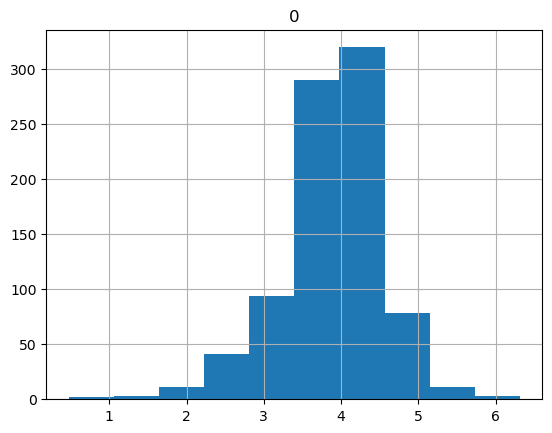

In [5]:
# take log of data and check 
logdata = jnp.log(data) 
_=pd.DataFrame(logdata[:,0]).hist()

Permuted data shape: 
 (853, 11)
Permutation: 
 [ 2  4  9  6  7  8 10  5  3  0  1]
Ground truth graphs: 



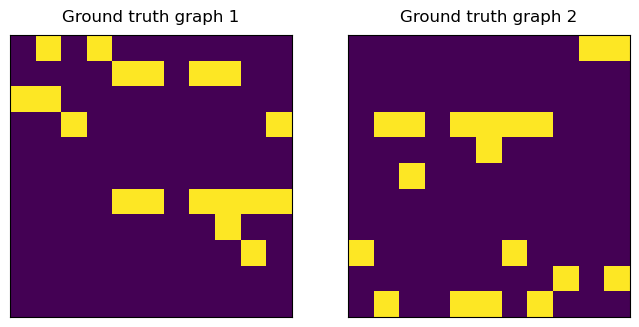

In [6]:
from vamsl.utils import visualize_ground_truths

# Permute data subset
logdata = jnp.log(data)[0:853,:]
key, subk = random.split(key)
perm_data, indicator, permutation = permute_random_rows(subk, logdata, p=0.5)

print('Permuted data shape: \n', perm_data.shape)
print('Permutation: \n', permutation)

ground_truth_graphs = [adjacency, permute_directed_graph(adjacency, permutation)]
print('Ground truth graphs: \n')
visualize_ground_truths(ground_truth_graphs)

In [7]:
# Process data
key, subk = random.split(key)
observed = random.bernoulli(subk, p=jnp.float32(0.8), shape=(perm_data.shape[0],))

X, X_lo = perm_data[observed], perm_data[~observed]
sc =  StandardScaler()
X, X_lo = sc.fit_transform(X), sc.transform(X_lo)

X_indicator, X_lo_indicator = indicator[observed],  indicator[~observed]

print('Observed data shape: \n', X.shape)
print('Left-out data shape: \n', X_lo.shape)

Observed data shape: 
 (683, 11)
Left-out data shape: 
 (170, 11)


In [8]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02,6.830000e+02
mean,1.675562e-08,-1.117042e-08,2.792604e-09,6.283359e-09,-3.839831e-09,2.792604e-09,9.774115e-09,8.377812e-09,-2.792604e-09,-2.792604e-09,2.792604e-09
std,1.000733e+00,1.000732e+00,1.000732e+00,1.000733e+00,1.000733e+00,1.000733e+00,1.000733e+00,1.000733e+00,1.000733e+00,1.000732e+00,1.000733e+00
min,-3.808854e+00,-4.115134e+00,-4.260251e+00,-2.490951e+00,-2.665147e+00,-2.858577e+00,-3.738360e+00,-2.176283e+00,-2.532769e+00,-4.774830e+00,-3.794764e+00
25%,-6.631817e-01,-5.830964e-01,-5.089300e-01,-7.068407e-01,-8.809380e-01,-5.330938e-01,-6.297362e-01,-8.867029e-01,-5.259213e-01,-6.438258e-01,-5.390702e-01
50%,5.582034e-02,1.258524e-03,7.570880e-02,-1.925092e-01,-5.209684e-02,1.561078e-01,-3.873385e-02,1.243842e-01,-3.908803e-02,2.538992e-02,-4.737192e-02
75%,7.266361e-01,6.396360e-01,6.489277e-01,6.397110e-01,8.787253e-01,6.629165e-01,5.818537e-01,8.818751e-01,6.445429e-01,7.146143e-01,5.099663e-01
max,3.037345e+00,5.066587e+00,2.871720e+00,5.000125e+00,2.240486e+00,3.063869e+00,2.781589e+00,1.855730e+00,2.503200e+00,4.095984e+00,3.322771e+00


In [9]:
# Unpermuted data set
pd.DataFrame(X[~X_indicator,:]).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.658856,0.047237,-0.434868,0.260948,-0.877204,0.160265,0.167609,0.901747,-0.616326,-0.331953,-0.003770
std,0.715613,0.886919,1.006292,1.125287,0.503208,0.932931,0.784282,0.385226,0.768189,0.845357,1.226143
min,-2.018734,-4.115134,-4.260251,-2.490951,-2.665147,-2.858577,-3.130732,-1.393755,-2.532769,-2.888670,-3.794764
25%,0.301452,-0.451953,-0.844674,-0.687739,-1.165605,-0.409810,-0.288062,0.711162,-1.142915,-0.850313,-0.775570
50%,0.687029,-0.010707,-0.325830,0.218976,-0.851571,0.249160,0.163994,0.872854,-0.414747,-0.304720,-0.166822
75%,1.115774,0.535452,0.150137,1.130389,-0.550992,0.738072,0.565961,1.123655,-0.054165,0.136498,1.036885
max,3.037345,3.803489,2.813328,3.414692,0.529391,3.063869,2.781589,1.855730,1.246220,2.146075,3.172570


In [10]:
# Permuted data set
pd.DataFrame(X[X_indicator,:]).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000
mean,-0.668574,-0.047933,0.441282,-0.264797,0.890143,-0.162629,-0.170081,-0.915047,0.625416,0.336849,0.003825
std,0.781615,1.103573,0.778032,0.772063,0.431162,1.041540,1.157112,0.450274,0.801850,1.034194,0.703572
min,-3.808854,-3.558414,-3.669691,-2.402772,-2.275588,-2.858577,-3.738360,-2.176283,-2.448201,-4.774830,-3.794764
25%,-1.013222,-0.761616,0.000287,-0.723505,0.697811,-0.891834,-0.864631,-1.182664,-0.035371,-0.166690,-0.385585
50%,-0.572353,0.001259,0.472144,-0.320540,0.881407,0.036972,-0.319426,-0.886703,0.637315,0.473560,0.003208
75%,-0.234210,0.677823,0.903446,0.014659,1.104869,0.593537,0.757248,-0.674314,1.246220,0.986788,0.365581
max,1.978437,5.066587,2.871720,5.000125,2.240486,2.316211,2.443130,1.767521,2.503200,4.095984,3.322771


### Create VaMSL model

In [11]:
from vamsl.models.graph import ErdosReniDAGDistribution, ScaleFreeDAGDistribution, UniformDAGDistributionRejection
from vamsl.models import MixtureLinearGaussian, MixtureDenseNonlinearGaussian
from vamsl.models import LinearGaussian, DenseNonlinearGaussian
from vamsl.target import make_graph_model

# BN settings
n_vars = X.shape[1] # number of variables in each component BN
struct_eq_type = 'linear' # BN function class: 'linear' or 'nonlinear'
graph_type = 'er' # Random graph structure: 'sf' (scale-free) or 'er' (Erdos-Renyi)

# Derived variables
n_components = len(jnp.unique(indicator))
linear = True if struct_eq_type == 'linear' else False

# Model specification 
graph_model = make_graph_model(n_vars=n_vars, graph_prior_str=graph_type, edges_per_node=2)
lik = MixtureLinearGaussian(n_vars=n_vars, obs_noise=0.1)  
component_lik = LinearGaussian(n_vars=n_vars, obs_noise=0.1)#, hidden_layers=(5,))

In [12]:
from vamsl.inference import VaMSL

# Create VaMSL and initialize posteriors
vamsl = VaMSL(x=X, graph_model=graph_model, mixture_likelihood_model=lik, component_likelihood_model=component_lik)
key, subk = random.split(key)
vamsl.initialize_posteriors(key=subk, n_components=n_components, n_particles=7, linear=linear)#, init_q_c=1/2*jnp.ones((X.shape[0],2)))

print('Posterior shapes:')
posts = vamsl.get_posteriors()
print('q_z:     ' + str(posts[0].shape)) # [n_components, n_particls, d, l, 2]
print('q_theta: ' + str(posts[1].shape)) if linear else print('q_theta: ' + str(len(posts[1]))) # leading dim of n_components
print('log_q_c: ' + str(posts[2].shape)) # [n_observations, n_components]
print('q_pi:    ' + str(posts[3].shape)) # [n_components,]

Posterior shapes:
q_z:     (2, 7, 11, 11, 2)
q_theta: (2, 7, 11, 11)
log_q_c: (683, 2)
q_pi:    (2,)


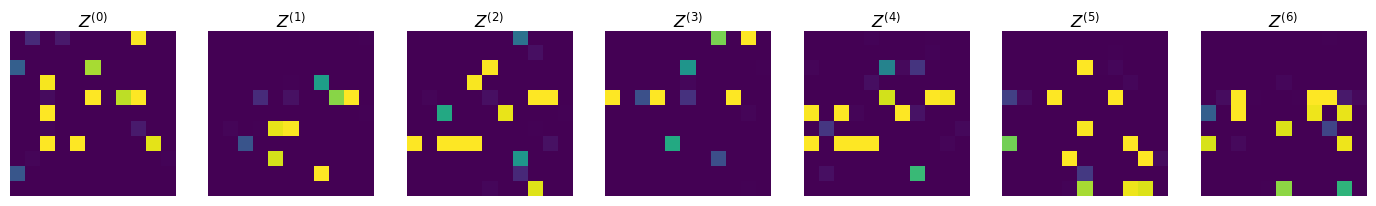

Component   1 | iteration 200 | alpha   10.0 | beta  200.0 | #cyclic   6


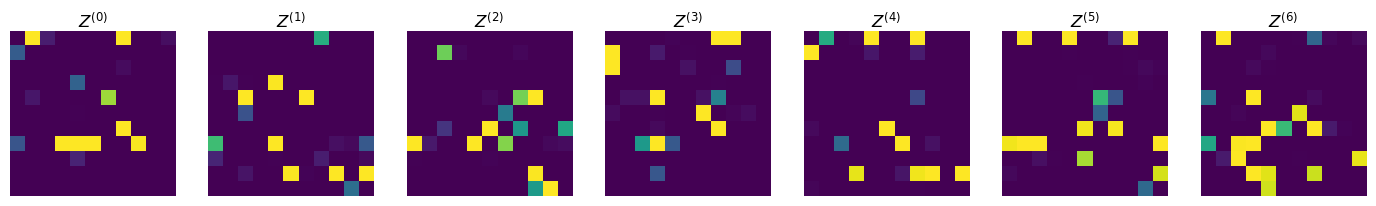

Component   2 | iteration 200 | alpha   10.0 | beta  200.0 | #cyclic   7
CAVI update number 7/10
MAP clustering: 
 [[344   0]
 [339   0]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# CAVI and SVGD vars
n_cavi_updates, steps = 10, 200

# CAVI-loop
for cavi_update in range(n_cavi_updates):
    key, subk = random.split(key)
    # Optimize q(Z, \Theta)
    vamsl.update_particle_posteriors(key=subk, steps=steps, callback_every=steps,
                                     callback=vamsl.visualize_callback(), linear=linear)

    # Update to optimal q(c) and q(\pi)
    vamsl.update_responsibilities_and_weights()
    print(f'CAVI update number {cavi_update+1}/{n_cavi_updates}')
    
    # Print current clustering
    order = vamsl.identify_MAP_classification_ordering(ground_truth_indicator=X_indicator)
    y_pred = [order[k] for k in [jnp.argmax(c_i) for c_i in vamsl.get_posteriors()[2]]]
    print('MAP clustering: \n', confusion_matrix(X_indicator, y_pred))
    
# Final CAVI update with more SVGD steps to ensure annealing unto acyclic graphs
key, subk = random.split(key)
vamsl.update_particle_posteriors(key=subk, steps=2000, callback_every=200, callback=vamsl.visualize_callback(), linear=linear)
vamsl.update_responsibilities_and_weights()

In [17]:
# Compute optimal ordering with respect to MAP classification accuracy
order = vamsl.identify_MAP_classification_ordering(ground_truth_indicator=X_indicator)
print('Optimal order:')
print(order)

Optimal order:
[1 0]


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

print('Sums of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2]), axis=0))
print('Sum of entropy of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2])*vamsl.get_posteriors()[2]))
y_true, order = X_indicator, vamsl.identify_MAP_classification_ordering(ground_truth_indicator=X_indicator)
y_pred = [order[k] for k in [jnp.argmax(c_i) for c_i in vamsl.get_posteriors()[2]]]
if n_components==2:
    print('Classification report:')
    print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['Component 1', 'Component 2']))
confusion_matrix(y_true, y_pred)

Sums of responsibilities:
[782.2688    21.731184]
Sum of entropy of responsibilities:
-0.84440386
Classification report:
              precision    recall  f1-score   support

 Component 1       0.59      0.03      0.06       385
 Component 2       0.52      0.98      0.68       419

    accuracy                           0.53       804
   macro avg       0.56      0.51      0.37       804
weighted avg       0.56      0.53      0.39       804



array([[ 13, 372],
       [  9, 410]])

In [19]:
from vamsl.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

# Get component datasets
datas = [X[(X_indicator==k).flatten(),:] for k in range(n_components)]

# Loop over components and calculate metrics
for k, data, q_z_k, q_theta_k in zip(range(n_components), datas, vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[order[k]])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate metrics
    eshd = expected_shd(dist=dist, g=ground_truth_graphs[order[k]])       
    auroc = threshold_metrics(dist=dist, g=ground_truth_graphs[order[k]])['roc_auc']
    #negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=data.x_ho)
    
    print(f' Component {k+1:4d} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}')#    neg. LL {negll:5.2f}')

 Component    1 |  E-SHD: 23.5    AUROC:  0.54
 Component    2 |  E-SHD: 26.7    AUROC:  0.50


In [20]:
vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()

Array([0.9717975 , 0.02820246], dtype=float32)

In [21]:
# Calculate neg log liks for posterior assignment probabilities
mixing_probs = vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()
negll = 0
for i in range(X_lo.shape[0]):
    temp_negll = 0
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        temp_negll += mixing_probs[k] * neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
    negll += temp_negll
    
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 163.91


In [22]:
# Calculate neg log liks for MAP assignments 
negll = 0
rs = np.zeros((X_lo.shape[0], n_components))
for i in range(X_lo.shape[0]):
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        rs[i,k] = vamsl.compute_log_responsibility(X_lo[i,:].reshape((1,-1)), dist, vamsl.get_posteriors()[3][k])
        
    q_g_k = vamsl.particle_to_g_lim(vamsl.get_posteriors()[0][np.argmax(rs[i])], vamsl.get_E()[np.argmax(rs[i])])
    dist = vamsl.get_empirical(q_g_k, vamsl.get_posteriors()[1][np.argmax(rs[i])])
    negll += neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
print('held-out responsibilities:', -rs.sum(axis=0)/X_lo.shape[0])
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

held-out responsibilities: [158.0114715  371.71396956]
neg. LL 157.51


### STANDARDIZED

In [24]:
# Compute optimal ordering with respect to MAP classification accuracy
order = vamsl.identify_MAP_classification_ordering(ground_truth_indicator=X_indicator)
print('Optimal order:')
print(order)

Optimal order:
[0 1]


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

print('Sums of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2]), axis=0))
print('Sum of entropy of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2])*vamsl.get_posteriors()[2]))
y_true, order = X_indicator, vamsl.identify_MAP_classification_ordering(ground_truth_indicator=X_indicator)
y_pred = [order[k] for k in [jnp.argmax(c_i) for c_i in vamsl.get_posteriors()[2]]]
if n_components==2:
    print('Classification report:')
    print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['Component 1', 'Component 2']))
confusion_matrix(y_true, y_pred)

Sums of responsibilities:
[534.7413 274.2587]
Sum of entropy of responsibilities:
-54.893646
Classification report:
              precision    recall  f1-score   support

 Component 1       0.50      0.67      0.57       400
 Component 2       0.52      0.35      0.42       409

    accuracy                           0.51       809
   macro avg       0.51      0.51      0.49       809
weighted avg       0.51      0.51      0.49       809



array([[266, 134],
       [266, 143]])

In [28]:
from vamsl.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

# Get component datasets
datas = [X[(X_indicator==k).flatten(),:] for k in range(n_components)]

# Loop over components and calculate metrics
for k, data, q_z_k, q_theta_k in zip(range(n_components), datas, vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[order[k]])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate metrics
    eshd = expected_shd(dist=dist, g=ground_truth_graphs[order[k]])       
    auroc = threshold_metrics(dist=dist, g=ground_truth_graphs[order[k]])['roc_auc']
    #negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=data.x_ho)
    
    print(f' Component {k+1:4d} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}')#    neg. LL {negll:5.2f}')

 Component    1 |  E-SHD: 21.8    AUROC:  0.60
 Component    2 |  E-SHD: 25.3    AUROC:  0.53


### Predictive performance

In [29]:
vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()

Array([0.6605935 , 0.33940652], dtype=float32)

In [30]:
# Calculate neg log liks for posterior assignment probabilities
mixing_probs = vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()
negll = 0
for i in range(X_lo.shape[0]):
    temp_negll = 0
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        temp_negll += mixing_probs[k] * neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
    negll += temp_negll
    
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 59.43


In [31]:
# Calculate neg log liks for MAP assignments 
negll = 0
rs = np.zeros((X_lo.shape[0], n_components))
for i in range(X_lo.shape[0]):
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        rs[i,k] = vamsl.compute_log_responsibility(X_lo[i,:].reshape((1,-1)), dist, vamsl.get_posteriors()[3][k])
        
    q_g_k = vamsl.particle_to_g_lim(vamsl.get_posteriors()[0][np.argmax(rs[i])], vamsl.get_E()[np.argmax(rs[i])])
    dist = vamsl.get_empirical(q_g_k, vamsl.get_posteriors()[1][np.argmax(rs[i])])
    negll += neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
print('held-out responsibilities:', -rs.sum(axis=0)/X_lo.shape[0])
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

held-out responsibilities: [57.43323966 65.20636098]
neg. LL 53.90


### Performance of DiBS

In [ ]:
from vamsl.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

# Get component datasets
datas = [X[(indicator==k).flatten(),:] for k in range(n_components)]

# Loop over components and calculate metrics
for k, data, q_z_k, q_theta_k in zip(range(n_components), datas, vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[order[k]])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate metrics
    eshd = expected_shd(dist=dist, g=ground_truth_graphs[order[k]])       
    auroc = threshold_metrics(dist=dist, g=ground_truth_graphs[order[k]])['roc_auc']
    #negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=data.x_ho)
    
    print(f' Component {k+1:4d} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}')#    neg. LL {negll:5.2f}')

### Comparison with GMM

In [ ]:
import numpy as np
from sklearn.mixture import BayesianGaussianMixture

labels = BayesianGaussianMixture(n_components=2, random_state=42).fit_predict(X)
print("Unstandardized clustering:\n", confusion_matrix(indicator, labels))

labels = BayesianGaussianMixture(n_components=2, random_state=42).fit_predict(jax.nn.standardize(X, axis=0))
print("Standardized clustering:\n", confusion_matrix(indicator, labels))